# Comparison of experimental data with model predictions
This notebook is intended as a guide for comparison of material model data against equivalent experimental measurements. This can be useful for validation of model parameters and understanding how consideration of different mechanisms in modelling effect material property predictions.

To use this notebook you should already have saved the modelling and simulation data you wish to compare in advance.
This notebook is does not calculate on or manipulate pre-existing data.

In [1]:
# Firstly, load in the required python libraries and functions:
# libraries and functions from the web:
import numpy as np
import pandas as pd
from matflow import load_workflow
import pickle
from cycler import cycler
import matplotlib.pyplot as plt
# libraries and functions local to this repository:
from utils import import_diff_params
from lattice_strain import lattice_strain
from plotting import plot_latticestrain
from plotting import plot_truestrain_peakint
from plotting import plot_lattice_strain_dist_inc

---
## Load data
It is recommended you use python pandas module to load in and select data, as this has been shown to be the fastest method.

In [2]:

# load in in-situ experimental stress-strains
ETMT_out = pd.read_csv('/mnt/eps01-rds/Fonseca-Lightform/shared/synchrotron_x-ray_diffraction/SXRD_analysis/diamond_2022/034_Ti64_TIFUN-T4_TD_Deform_910C_1mms-1/ETMT-output/ETMT_output_034.txt', sep=",")

area = 8
guage_length = 2

ETMT_eng_stress = ETMT_out.iloc[:, 1]/area
ETMT_eng_strain = ETMT_out.iloc[:, 2]/guage_length
ETMT_true_strain = np.log(1+ETMT_eng_strain)
ETMT_true_stress = ETMT_eng_stress*(1+ETMT_eng_strain)

# load in experimental lattice strains
exp_microstrain = pd.read_csv('/mnt/iusers01/jf01/y15576gb/postprocessing/\
Microstrain_true_stress_load_direction_34.txt', sep="\t")
exp_stress = exp_microstrain.iloc[:,0]
exp_microstrain_prism = exp_microstrain.iloc[:,1]
exp_microstrain_basal = exp_microstrain.iloc[:,2]
exp_microstrain_pyram = exp_microstrain.iloc[:,3]
exp_microstrain_1120 = exp_microstrain.iloc[:,4]
exp_microstrain_beta110 = exp_microstrain.iloc[:,5]
exp_microstrain_beta200 = exp_microstrain.iloc[:,6]
# exp_microstrain_beta220 = exp_microstrain.iloc[:,7]


In [5]:
# define modelling data:
workflow_dir = "/mnt/iusers01/jf01/y15576gb/postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_elongated_TensionY64x_1mms-1_Xprism_alt0-plastic_CRSS_14_210_210_0_0_224_224_2023-12-12-113036/"


In [6]:
# load literature data:
# temp=900
# strainrate=0.1
# lit_stress_strain = pickle.load(open(workflow_dir+'lit_stress_strains.pkl', 'rb'))

---
## Plot in-situ, literature, model stress-strain data on same plot

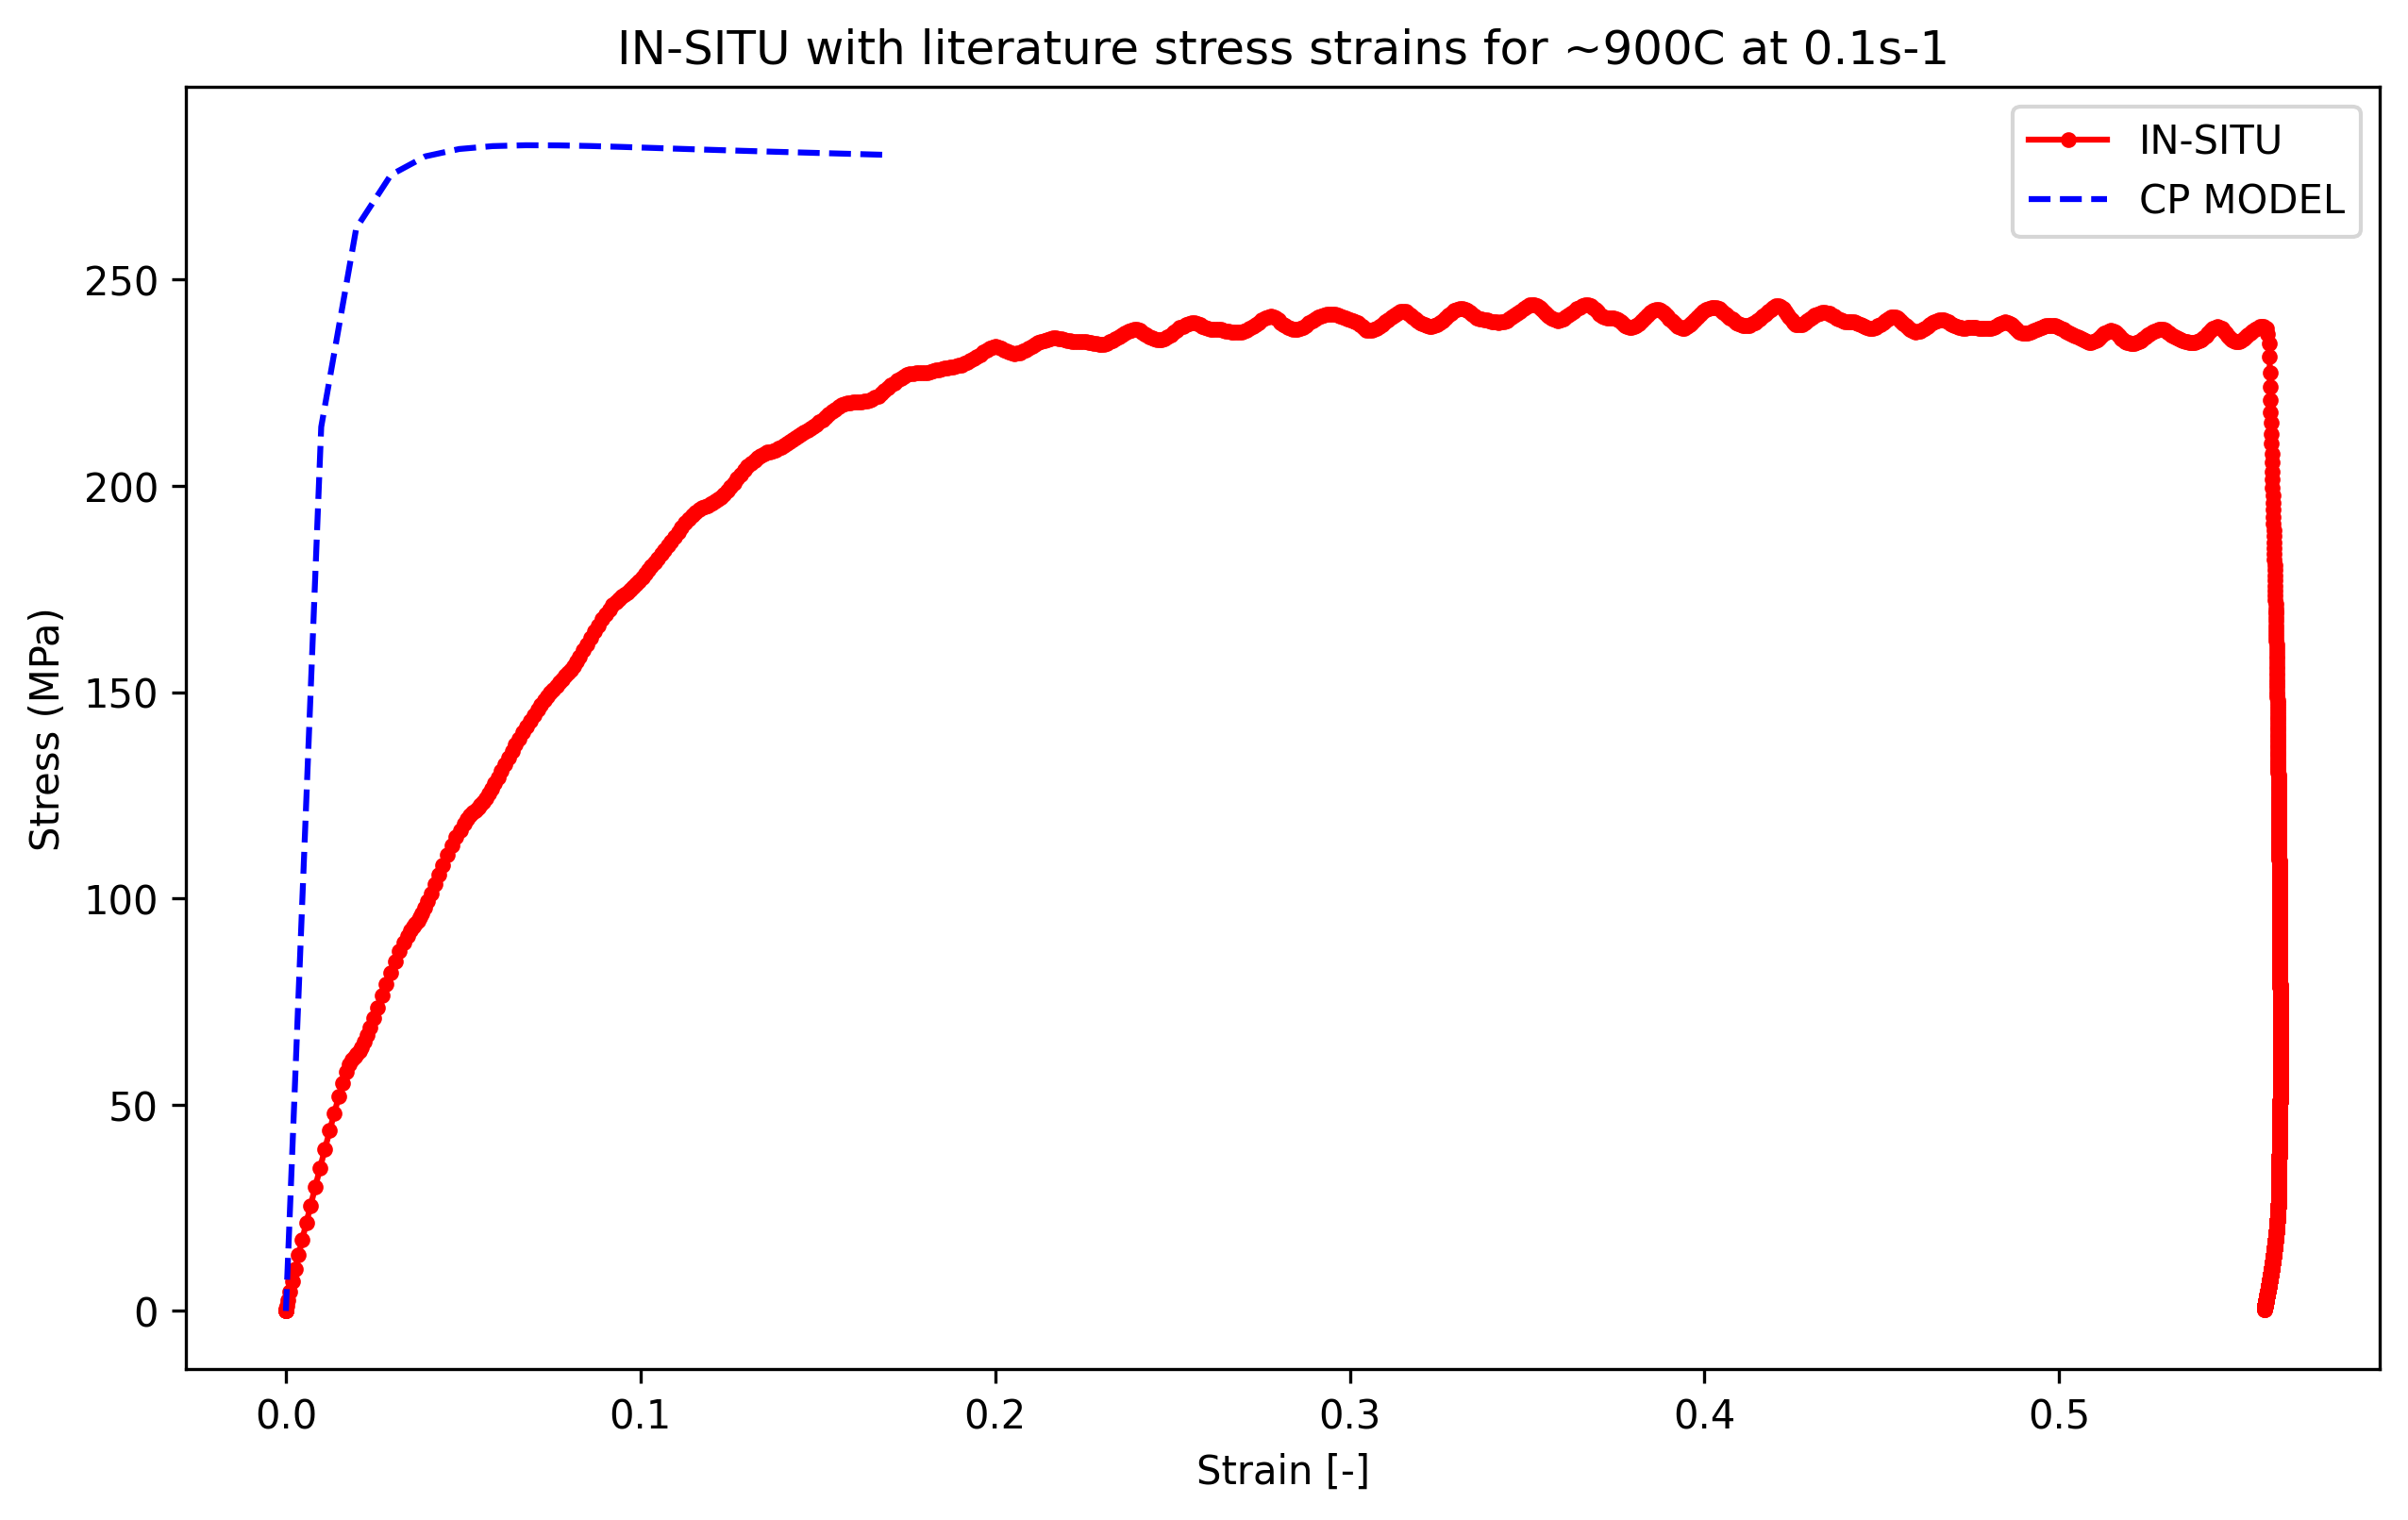

In [18]:

plt.figure(figsize=(10,6), dpi=300)

# plot in-situ experiment stress-strains
plt.plot(ETMT_true_strain[:], ETMT_true_stress[:], label='IN-SITU', color='r', marker='.')

# plot model stress-strain data
model_stress_strain = pickle.load(open(workflow_dir+'stress_strain.pkl', 'rb'))
model_stress = model_stress_strain['Y']['stress']
model_strain = model_stress_strain['Y']['strain']
plt.plot(model_strain[:], model_stress[:], linestyle='dashed', label='CP MODEL', color='b')

# plot literature stress-strain data
# for paper in lit_stress_strain['Papers'].keys():
#     for n, curve in enumerate(lit_stress_strain['Papers'][paper]['Curves']):
#         stress = lit_stress_strain['Papers'][paper]['Curves'][n]['data'][:,1]
#         strain = lit_stress_strain['Papers'][paper]['Curves'][n]['data'][:,0]
#         lit_temp = lit_stress_strain['Papers'][paper]['Curves'][n]['Temperature_C']
#         lit_strainrate = lit_stress_strain['Papers'][paper]['Curves'][n]['Strain_rate_s-1']
#         if temp == lit_temp and strainrate == lit_strainrate: # filter by defined T and sr
#             plt.plot(strain, stress,
#                      label=paper,
#                      alpha=0.5)

plt.xlabel("Strain [-]")
plt.ylabel("Stress (MPa)")
plt.title("IN-SITU with literature stress strains for ~900C at 0.1s-1")
plt.legend(bbox_to_anchor=[1, 1])


---
## Plot experimental and predicted microstrain for load direction on same plot

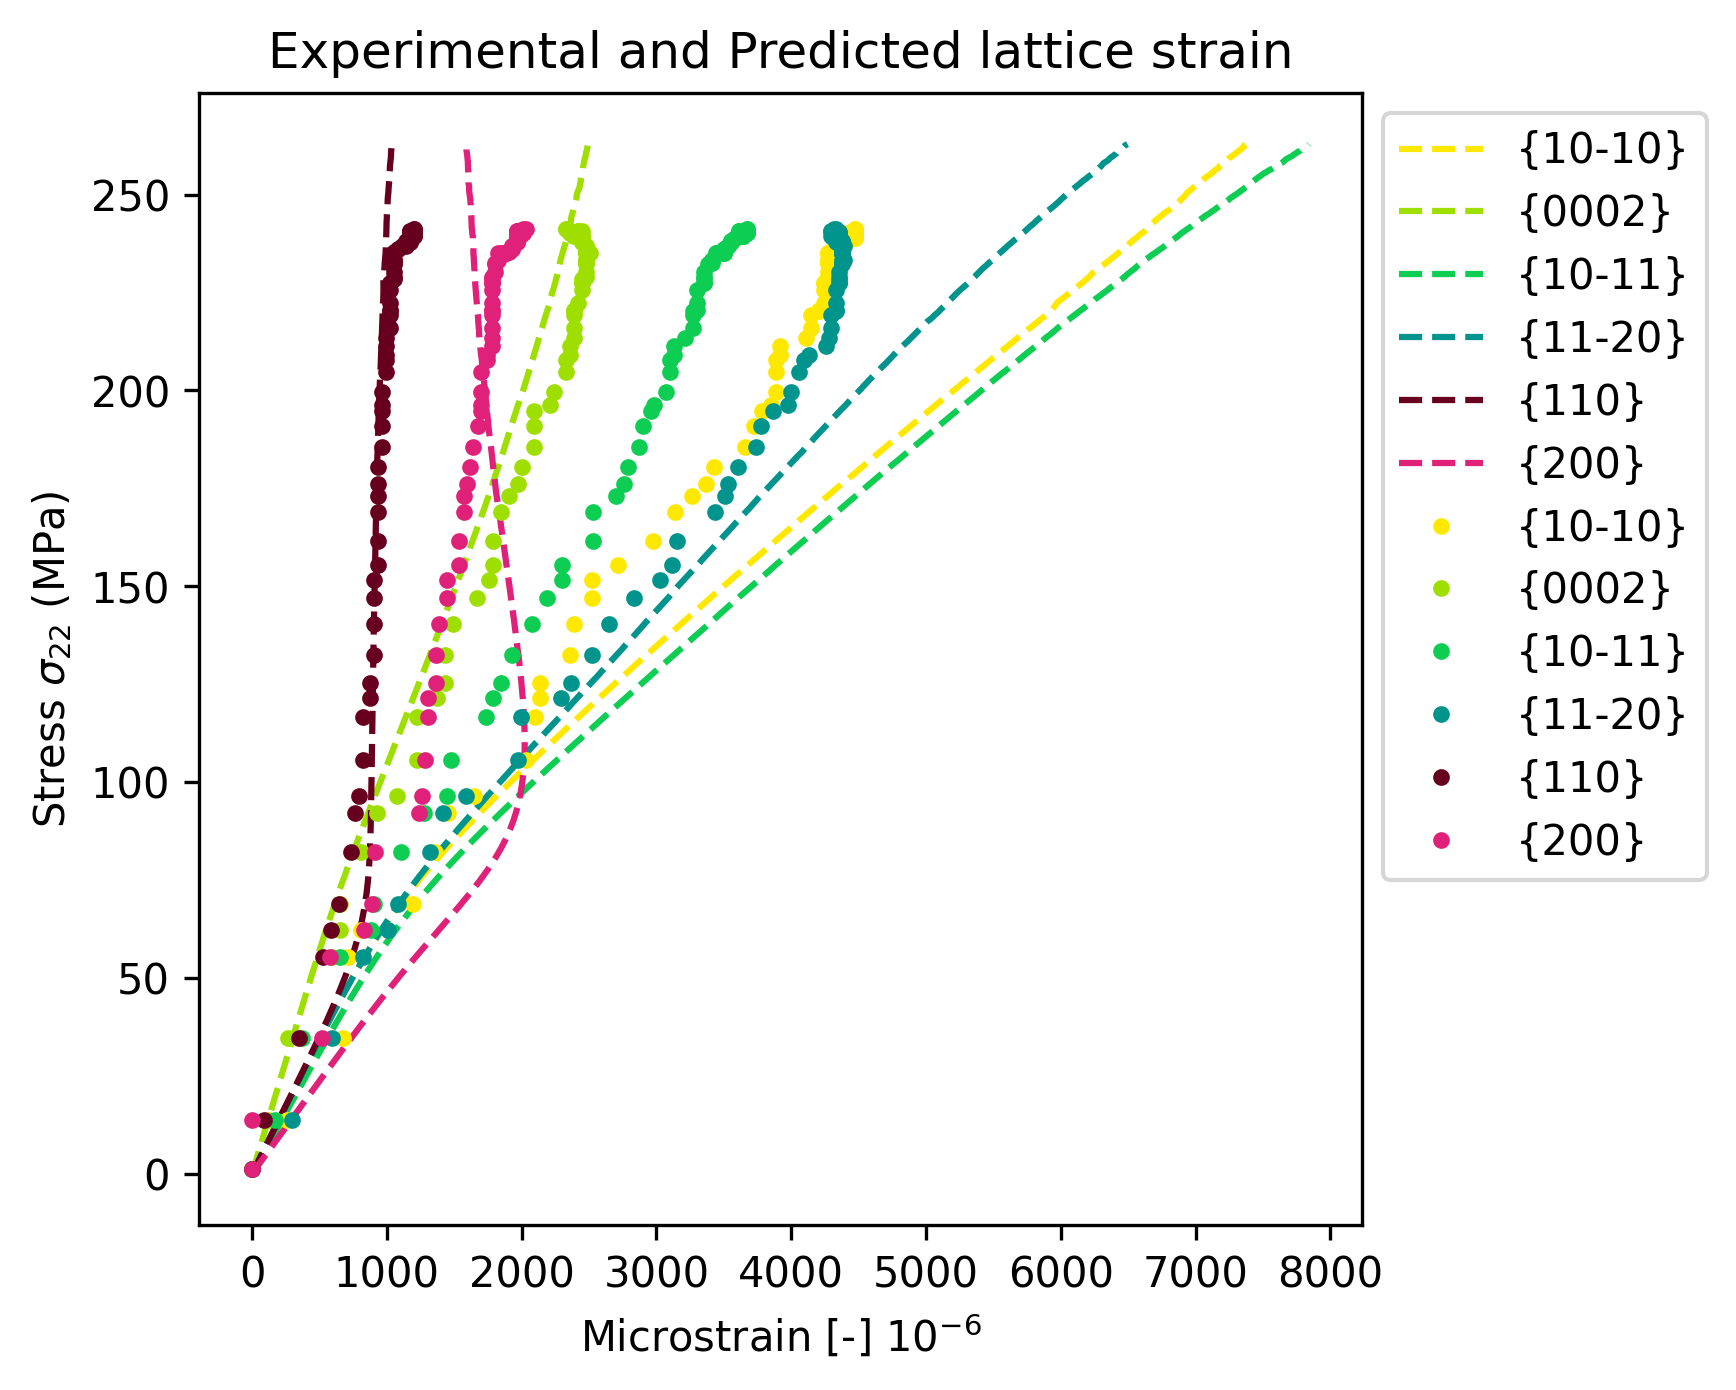

In [5]:
# load in model prediction data from .pkls:

diff_params, defdap_phases = import_diff_params("Ti_alpha", "Ti_beta")

dont_include = ['{220}']
fig, axs = plt.subplots(1,1, figsize=(5, 5), dpi=300, facecolor='w')

stress_strain = pickle.load(open(workflow_dir+'stress_strain.pkl', 'rb'))
true_stress = pickle.load(open(workflow_dir+'stress_strain.pkl', 'rb'))["Y"]['stress']
latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

latticestrain_mean = {}
for phase_name, latticestrain_phase in latticestrain['Y'].items():
    latticestrain_phase_mean = {}
    for plane_label, strains in latticestrain_phase.items():
        latticestrain_phase_mean[plane_label] = np.array([strain.mean() for strain in strains])
    latticestrain_mean[phase_name] = latticestrain_phase_mean
for phase in ['Ti_alpha', 'Ti_beta']:
    for plane_label, mean_strain in latticestrain_mean[phase].items():
        total_microstrain = np.array([0] + mean_strain) * 1e6 # convert to microstrain (1e6)
        plane_colour = diff_params[phase]['diffraction_planes'][plane_label]['colour']
        plane_marker = diff_params[phase]['diffraction_planes'][plane_label]['marker']
        if plane_label in dont_include:
            pass
        else:
            plt.plot(total_microstrain, true_stress,
                        color=plane_colour, linestyle='dashed',
                        label=plane_label)

plt.title('Experimental and Predicted lattice strain')
plt.ylabel('Stress $\sigma_{{22}}$ (MPa)')
plt.xlabel('Microstrain [-] $10^{{-6}}$')
plt.plot(exp_microstrain_prism, exp_stress, label='{10-10}', marker='o', markersize=3, color='#FFE800', linestyle='None')
plt.plot(exp_microstrain_basal, exp_stress, label='{0002}', marker='o', markersize=3, color='#9FDF00', linestyle='None')
plt.plot(exp_microstrain_pyram, exp_stress, label='{10-11}', marker='o', markersize=3, color='#0DCD52', linestyle='None')
plt.plot(exp_microstrain_1120, exp_stress, label='{11-20}', marker='o', markersize=3, color='#00948D', linestyle='None')
plt.plot(exp_microstrain_beta110, exp_stress, label='{110}', marker='o', markersize=3, color='#67001F', linestyle='None')
plt.plot(exp_microstrain_beta200, exp_stress, label='{200}', marker='o', markersize=3, color='#DF2179', linestyle='None')
# plt.plot(exp_microstrain_beta220, exp_stress, label='exp_beta220', marker='.', markersize=1, linestyle='dashed', color='#CDA0CD')
plt.legend(bbox_to_anchor=(1,1))